In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from io import BytesIO
from IPython.display import display, Image
from PIL import Image as PILImage
import requests
import json
import pandas as pd

In [4]:
PROJECT_SUBDIR = r'/Develop/TrailSight'
COLAB_PATH = '/content/drive/MyDrive'
BASE_PATH = COLAB_PATH
PROJECT_DIR = BASE_PATH + PROJECT_SUBDIR
MODEL_PATH = PROJECT_DIR + 'bbox_weights.pth'
BBOX_FOLDER = PROJECT_DIR + '/bbox_data'

In [5]:
def load_metadata(metadata_path: str):
  with open(metadata_path, 'r') as f:
      metadata = json.load(f)
  return metadata

In [6]:
metadata = load_metadata(f"{PROJECT_DIR}/idaho-camera-traps.json")
categoeries = pd.DataFrame(metadata['categories'])
annotations = pd.DataFrame(metadata['annotations'])
images = pd.DataFrame(metadata['images'])
images_annotations = pd.merge(annotations, images, left_on='image_id', right_on='id', how='inner', suffixes=('_annotation', '_img'))
images_annotations = images_annotations[~images_annotations['category_id'].isin([29, 1, 48, 32, 26,	34 ,54])].reset_index(drop=True)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    images_annotations,
    test_size=0.2,
    stratify=images_annotations['category_id'],
    random_state=42
)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [7]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class AnimalsDataset(Dataset):
    def __init__(self, images: pd.DataFrame, labels: pd.DataFrame):
      self.categoeries = labels # this is not y, it simply maps the class id to name
      self.images_annotations = images # x, y and other metadata
      self.transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
      ])

    def fetch_image(self, idx):
      path = self.images_annotations.iloc[idx]['file_name']
      gcp_url = f"https://storage.googleapis.com/public-datasets-lila/idaho-camera-traps/public/{path}"
      aws_url = f"http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/idaho-camera-traps/public/{path}"
      azure_url = f"https://lilawildlife.blob.core.windows.net/lila-wildlife/idaho-camera-traps/public/{path}"
      urls = [gcp_url, aws_url, azure_url]

      for url in urls:
        try:
          response = requests.get(url, timeout=5)
          if response.status_code == 200:
            img_data = response.content
            return self.transform(PILImage.open(BytesIO(img_data))), self.images_annotations.iloc[idx]['file_name']
        except Exception as e:
          continue

      return self.create_placeholder_image(path)

    def create_placeholder_image(self, path):
      print(f"WARNING Image not found. {path}. Defaulting to empty image.")
      return torch.load("/content/drive/MyDrive/Develop/mean_image_tensor.pt"), -1

    def __len__(self):
      return len(self.images_annotations)

    def __getitem__(self, idx):
      return self.fetch_image(idx)

    def idx_to_class(self, idx):
      if idx > len(self.categoeries):
        raise Exception("Index out of range")
      return self.categoeries.loc[idx, 'name']

In [8]:
train_data = AnimalsDataset(train_df, categoeries)

In [9]:
from collections import Counter
labels = train_data.images_annotations['category_id'].tolist()
class_counts = Counter(labels)

class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in labels]

from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [10]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs = torch.stack(inputs, dim=0)
    return inputs, list(labels)

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_data,
    batch_size=10,
    sampler=sampler,
    collate_fn=collate_fn
)

In [12]:
device = torch.device("cuda")

In [13]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [14]:
from ultralytics import YOLO
model = YOLO("yolov8x")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 131M/131M [00:00<00:00, 230MB/s]


In [19]:
imgs, _ = next(iter(train_loader))

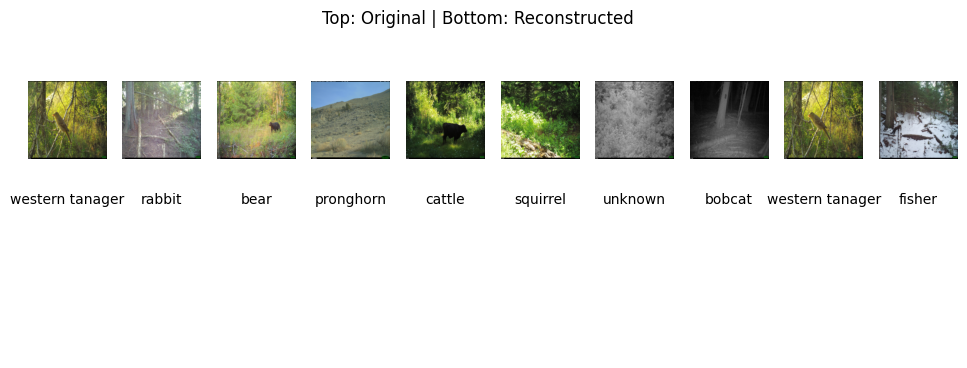

In [41]:
def show_images(original, labels):
    n = len(original)
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].permute(1, 2, 0).cpu().numpy())
        plt.axis("off")
        ax = plt.subplot(2, n, n + i + 1)
        plt.axis("off")
        ax.set_title(str(train_data.idx_to_class(int(labels[i]))), fontsize=10, pad=10)
    plt.suptitle("Top: Original | Bottom: Reconstructed")
    plt.show()

show_images(imgs, _)

In [ ]:
animal_boxes = []

In [97]:
import json
for imgs, file_names in train_loader:
  results = model.predict(
      imgs,
      imgsz=224,
      conf=0.25,
      verbose=False
  )
  print(len(results[0].boxes), len(file_names))
  for idx, img_path in enumerate(file_names):
    if img_path == -1: continue
    result = results[idx]
    if len(result.boxes) != 0:
      box = result.boxes[0]
      conf = float(box.conf[0])
      cls_id = int(box.cls[0])
      coco_class_name = model.names[cls_id].lower()
      x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
      bbox = {
          'bbox': [float(x1), float(y1), float(x2-x1), float(y2-y1)],
          'species': coco_class_name,
          'confidence': conf
      }
      file_name = img_path.replace('.jpg', '.json')
      file_name = file_name.replace('/', '')
      with open(BBOX_FOLDER + '/' + file_name, 'w') as file:
        json.dump(bbox, file)
      print(f"Saved to {BBOX_FOLDER + '/' + file_name}")
    else:
      print(f"No detections for image {img_path} (Index {idx})")

Streaming output truncated to the last 5000 lines.
Saved to /content/drive/MyDrive/Develop/TrailSight/bbox_data/loc_0219loc_0219_im_000295.json
Saved to /content/drive/MyDrive/Develop/TrailSight/bbox_data/loc_0083loc_0083_im_001149.json
No detections for image loc_0039/loc_0039_im_007335.jpg (Index 6)
No detections for image loc_0037/loc_0037_im_011380.jpg (Index 7)
Saved to /content/drive/MyDrive/Develop/TrailSight/bbox_data/loc_0164loc_0164_im_000535.json
Saved to /content/drive/MyDrive/Develop/TrailSight/bbox_data/loc_0213loc_0213_im_001724.json
0 10
No detections for image loc_0098/loc_0098_im_002441.jpg (Index 0)
Saved to /content/drive/MyDrive/Develop/TrailSight/bbox_data/loc_0083loc_0083_im_003650.json
No detections for image loc_0047/loc_0047_im_009653.jpg (Index 2)
No detections for image loc_0016/loc_0016_im_015107.jpg (Index 3)
No detections for image loc_0047/loc_0047_im_001148.jpg (Index 4)
No detections for image loc_0262/loc_0262_im_005338.jpg (Index 5)
Saved to /content

KeyboardInterrupt: 

In [82]:
for idx, img_path in enumerate(file_names):
  if img_path == -1: continue
  result = results[idx]
  if len(result.boxes) != 0:
    print(f"Results for image {img_path} (Index {idx}):")
    box = result.boxes[0]
    conf = float(box.conf[0])
    cls_id = int(box.cls[0])
    coco_class_name = model.names[cls_id].lower()
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
    print(f"\tconf: {conf}. {x1}, {y1}, {x2}, {y2}. {coco_class_name}")
  else:
    print(f"No detections for image {img_path} (Index {idx})")

Results for image loc_0100/loc_0100_im_004585.jpg (Index 0):
	conf: 0.8839466571807861. 108.18671417236328, 130.48524475097656, 167.27239990234375, 220.1294403076172. cow
Results for image loc_0098/loc_0098_im_002439.jpg (Index 1):
	conf: 0.5068152546882629. 128.23760986328125, 143.82989501953125, 144.80841064453125, 190.53543090820312. bird
No detections for image loc_0128/loc_0128_im_003523.jpg (Index 2)
Results for image loc_0118/loc_0118_im_003502.jpg (Index 4):
	conf: 0.6213475465774536. 95.87440490722656, 120.26838684082031, 139.7708282470703, 157.45533752441406. sheep
No detections for image loc_0269/loc_0269_im_006237.jpg (Index 5)
Results for image loc_0070/loc_0070_im_000964.jpg (Index 6):
	conf: 0.6159034967422485. 6.6812744140625, 2.624725341796875, 220.4794464111328, 213.38595581054688. person
Results for image loc_0126/loc_0126_im_004205.jpg (Index 7):
	conf: 0.44337916374206543. 144.1472625732422, 116.45101928710938, 160.13844299316406, 139.54736328125. bird
No detection

In [23]:
import os

files = os.listdir(BBOX_FOLDER)
files = [f[:8] + '/' + f[8:] for f in files]

In [ ]:
for box_data in animal_boxes:
    x, y, w, h = box_data['bbox']
    species = box_data['species']
    conf = box_data['confidence']

    # Draw rectangle and text
    draw.rectangle([x, y, x+w, y+h], outline="red", width=3)
    label = f"{species} ({coco_class}, {conf:.2f})"
    draw.text((x, y-20), label, fill="red", font=font)